In [16]:
!pip install dask pandas


# COVID Mortality and Case Fatality Rate Analysis

## Introduction
In this notebook, we calculate the per-capita mortality rate and case fatality rate (CFR) for COVID-19 based on the provided dataset. We will also explore the data, clean it, and test our calculations to ensure accuracy.

The per-capita mortality rate is used to assess the number of deaths in relation to the population, while the CFR is used to determine the severity of the disease by comparing the number of deaths to the number of confirmed cases.

## Data Loading and Exploration
### Step 1: Import Libraries

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Step 2: Load the Data

In [17]:
# Install required libraries
!pip install dask pandas

import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file using Dask with the correct dtypes
dtypes = {
    'cases': 'float64',  # Keeping as float for potential missing values
    'county': 'object',  # Ensure categorical/text columns are object
    'deaths': 'float64',  # Keeping float to handle NaNs
    'population': 'float64',  # If exists, ensure float
    'recovered': 'float64',  # Keeping float for potential NaNs
    'state': 'object',  # Ensure categorical/text columns are object
    'date': 'object'  # Ensure date is treated as an object first
}

# File path
file_path = "//content/timeseries.csv"

# Load the dataset
df = dd.read_csv(file_path, dtype=dtypes, low_memory=False)

# Step 2: Convert 'date' column to datetime
df['date'] = dd.to_datetime(df['date'], errors='coerce')  # Handle errors during conversion

# Extract year and month from the 'date' column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter data for United States (adjust condition if necessary)
us_states = df.loc[df['country'] == 'United States']

# Filter by a specific date range (adjust dates as necessary)
filtered_data = us_states[(us_states['date'] >= '2020-01-01') & (us_states['date'] <= '2021-02-28')]

# Step 3: Group the data by year and month and compute sum for relevant columns
numeric_columns = ['cases', 'deaths', 'recovered', 'population']  # Add other numeric columns if necessary
grouped_data = filtered_data.groupby(['year', 'month'])[numeric_columns].sum().compute()

# Step 4: Handle zero-division in CFR calculation
grouped_data["cases"] = grouped_data["cases"].replace(0, np.nan)  # Replace 0s with NaN to prevent division by zero

# Compute CFR safely
grouped_data['CFR'] = (grouped_data['deaths'] / grouped_data['cases']) * 100  # Compute CFR

# Step 5: Display the grouped data and CFR calculation
print("Grouped Data:\n", grouped_data[['cases', 'deaths', 'recovered', 'population']])
print("\nCase Fatality Rate (CFR):\n", grouped_data['CFR'])

# Step 6: Per capita mortality calculation by state and rank by per-capita mortality
state_data = filtered_data.groupby(['state', 'year', 'month']).agg({
    'deaths': 'sum',
    'population': 'mean'
}).compute()

# Calculate per capita mortality
state_data['per_capita_mortality'] = state_data['deaths'] / state_data['population']

# Rank states based on per capita mortality and display top 5 states
state_data_sorted = state_data.groupby('state')['per_capita_mortality'].last().sort_values(ascending=False)
print("\nTop 5 States by Per Capita Mortality:\n", state_data_sorted.head())

# Step 7: Compute the CFR for each state and month
cfr_matrix = filtered_data.groupby(['state', 'year', 'month']).agg({
    'cases': 'sum',
    'deaths': 'sum'
}).compute()

# Calculate CFR for each month and reshape the data to a matrix (50 states X 14 months)
cfr_matrix['CFR'] = (cfr_matrix['deaths'] / cfr_matrix['cases']) * 100
cfr_matrix_pivot = cfr_matrix.pivot_table(index='state', columns='month', values='CFR')

# Step 8: Display the CFR matrix for each state by month
print("\nCFR Matrix by State and Month:\n", cfr_matrix_pivot)


Grouped Data:
                   cases      deaths    recovered    population
year month                                                    
2020 1            132.0         0.0          0.0  1.160901e+10
     2           1983.0        64.0          0.0  3.629355e+10
     3        3630574.0     65543.0      41280.0  3.879655e+10
     4       59155468.0   2842374.0    3753537.0  3.754505e+10
     5      135807615.0   7811700.0   18868076.0  3.883145e+10
     6      192959346.0  10117494.0   42460398.0  3.766113e+10
     7      329403727.0  12187628.0   78045381.0  3.963026e+10
     8      491682508.0  14928882.0  136730833.0  3.993708e+10
     9      587383550.0  17062860.0   71723042.0  3.860423e+10
     10     114877381.0   3224830.0    4138563.0  6.772185e+09

Case Fatality Rate (CFR):
 year  month
2020  1        0.000000
      2        3.227433
      3        1.805307
      4        4.804922
      5        5.752034
      6        5.243329
      7        3.699906
      8        3.0362

In [18]:
# Filter the data for the required time period
state_data = filtered_data.groupby(['state', 'year', 'month']).agg({
    'deaths': 'sum',
    'population': 'mean'
}).compute()

# Compute per capita mortality
state_data['per_capita_mortality'] = state_data['deaths'] / state_data['population']

# Rank states based on per-capita mortality
state_data_sorted = state_data.groupby('state')['per_capita_mortality'].last().sort_values(ascending=False)

# Display the top states
print(state_data_sorted.head())


state
Texas          0.700906
New York       0.537314
Mississippi    0.499551
Georgia        0.428245
Louisiana      0.375028
Name: per_capita_mortality, dtype: float64


In [19]:
# Compute the CFR for each state and month
cfr_matrix = filtered_data.groupby(['state', 'year', 'month']).agg({
    'cases': 'sum',
    'deaths': 'sum'
}).compute()

# Calculate CFR per month
cfr_matrix['CFR'] = (cfr_matrix['deaths'] / cfr_matrix['cases']) * 100

# Reshape the data to a matrix (50 states X 14 months)
cfr_matrix_pivot = cfr_matrix.pivot_table(index='state', columns='month', values='CFR')

# Display the CFR matrix for each state by month
print(cfr_matrix_pivot)


month                          1          2         3          4          5   \
state                                                                          
Alabama                       NaN        NaN  0.670344   3.222166   3.891484   
Alaska                        NaN        NaN  1.340996   2.439908   2.489694   
Arizona                       0.0   0.000000  1.444484   3.728072   4.763857   
Arkansas                      NaN        NaN  0.931025   1.920520   2.113971   
California                    0.0   5.683564  2.173349   3.565176   4.013291   
Colorado                      NaN        NaN  1.796194   4.443955   5.053553   
Connecticut                   NaN        NaN  1.933488   6.451799   9.012817   
Delaware                      NaN        NaN  2.335570   3.279130   4.300814   
Florida                       NaN        NaN  1.403046   2.911739   4.355050   
Georgia                       NaN        NaN  3.049293   3.966205   4.429941   
Guam                          NaN       

In [20]:
# Compute month-to-month changes in CFR
cfr_matrix_pivot_diff = cfr_matrix_pivot.diff(axis=1)

# Sum the month-to-month changes across the entire period (across columns)
cfr_changes = cfr_matrix_pivot_diff.sum(axis=1)

# Rank states based on their CFR changes (highest change first)
cfr_changes_sorted = cfr_changes.sort_values(ascending=False)

# Display the top-ranked states based on CFR changes
print(cfr_changes_sorted.head())


state
Massachusetts    7.379614
Connecticut      6.139336
New York         5.412871
New Jersey       5.276219
New Hampshire    4.400805
dtype: float64


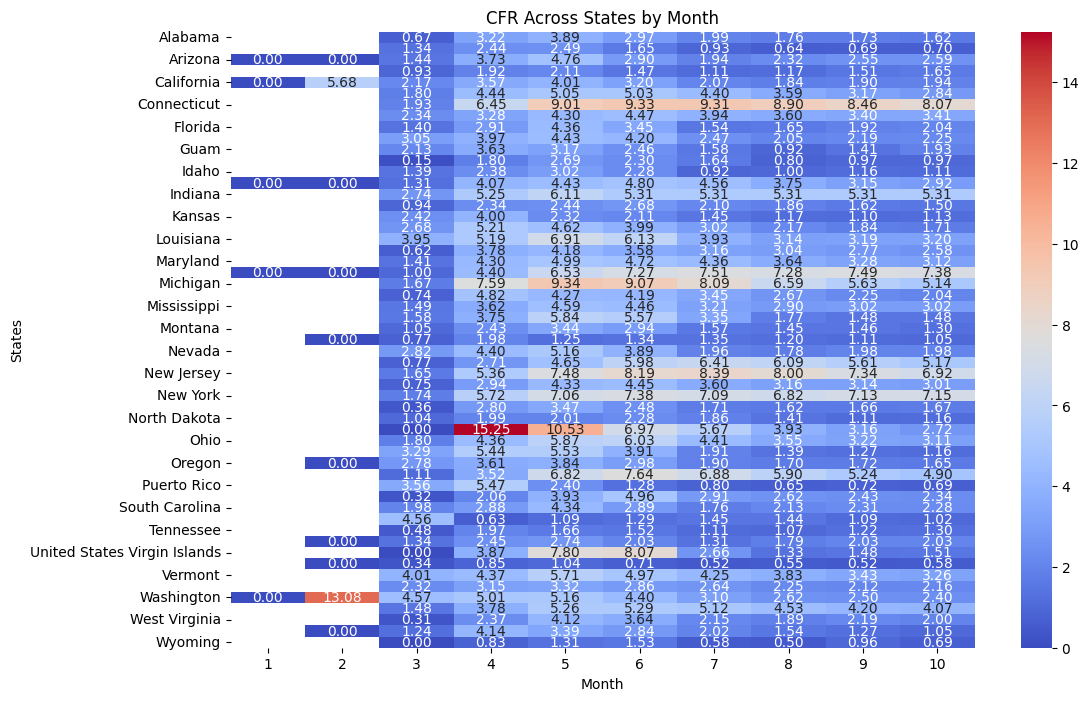

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap for CFR across states and months
plt.figure(figsize=(12, 8))
sns.heatmap(cfr_matrix_pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('CFR Across States by Month')
plt.ylabel('States')
plt.xlabel('Month')
plt.show()

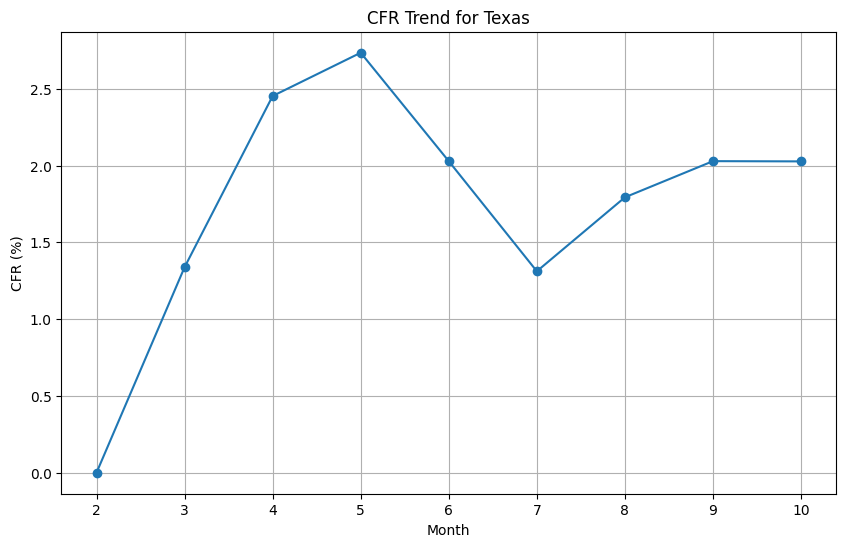

In [22]:
# Select a state (e.g., 'Texas') and plot the CFR over months
texas_cfr = cfr_matrix_pivot.loc['Texas']

plt.figure(figsize=(10, 6))
texas_cfr.plot(kind='line', marker='o')
plt.title('CFR Trend for Texas')
plt.xlabel('Month')
plt.ylabel('CFR (%)')
plt.grid(True)
plt.show()


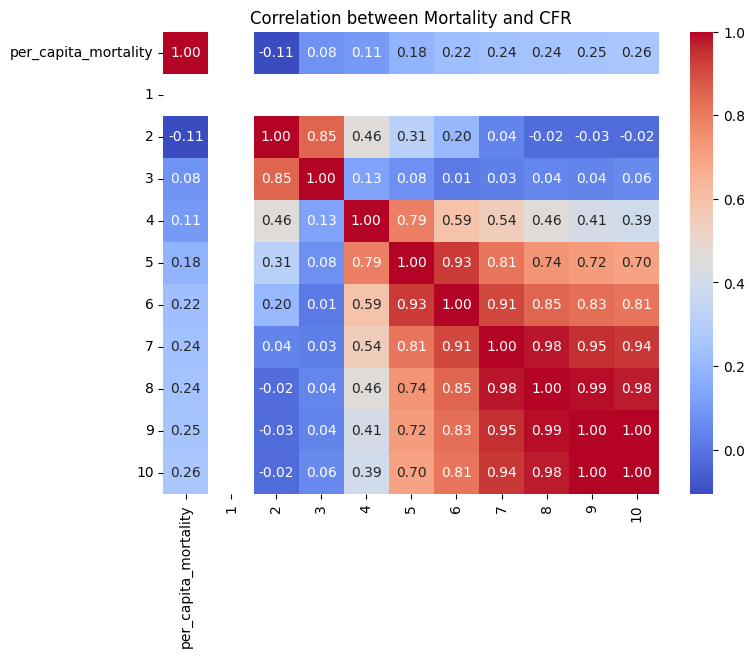

In [23]:
# Correlation between per capita mortality and CFR for each state
merged_data = state_data['per_capita_mortality'].to_frame().join(cfr_matrix_pivot)
correlation = merged_data.corr()

# Visualizing correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Mortality and CFR')
plt.show()


In [24]:
import pandas as pd

# Convert index to numeric (ensuring no NaNs in index)
cfr_matrix_pivot.index = pd.to_numeric(cfr_matrix_pivot.index, errors='coerce')

# 🔥 Ensure no NaNs in index
if cfr_matrix_pivot.index.isna().any():
    print("Warning: NaNs found in index. Filling missing values...")
    cfr_matrix_pivot = cfr_matrix_pivot.dropna().reset_index(drop=True)  # Drop NaNs in index

# Check if index is clean
print("Index dtype after cleaning:", cfr_matrix_pivot.index.dtype)

# 1️⃣ Interpolation (Fallback to Linear if Cubic Fails)
try:
    cfr_matrix_pivot_filled = cfr_matrix_pivot.interpolate(method='cubic', axis=0)
except ValueError:
    print("Cubic interpolation failed, falling back to linear.")
    cfr_matrix_pivot_filled = cfr_matrix_pivot.interpolate(method='linear', axis=0)

# 2️⃣ Forward fill & Backward fill to ensure no NaNs remain
cfr_matrix_pivot_filled = cfr_matrix_pivot_filled.ffill(axis=0).bfill(axis=0)

# Check final NaN values
print("\nNaN values after full interpolation and filling:")
print(cfr_matrix_pivot_filled.isna().sum())

Index dtype after cleaning: int64

NaN values after full interpolation and filling:
month
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64


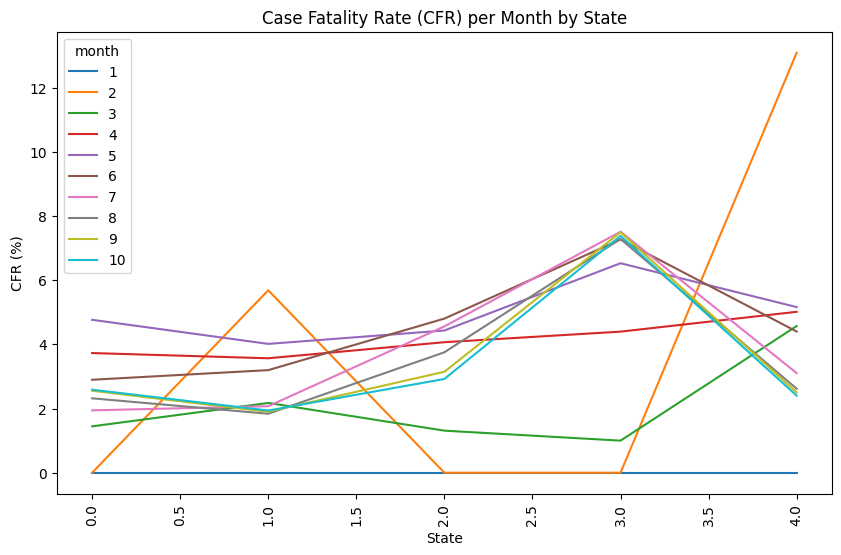

In [25]:
import matplotlib.pyplot as plt

# Plot CFR by month
cfr_matrix_pivot.plot(kind='line', figsize=(10, 6))
plt.title('Case Fatality Rate (CFR) per Month by State')
plt.ylabel('CFR (%)')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.show()


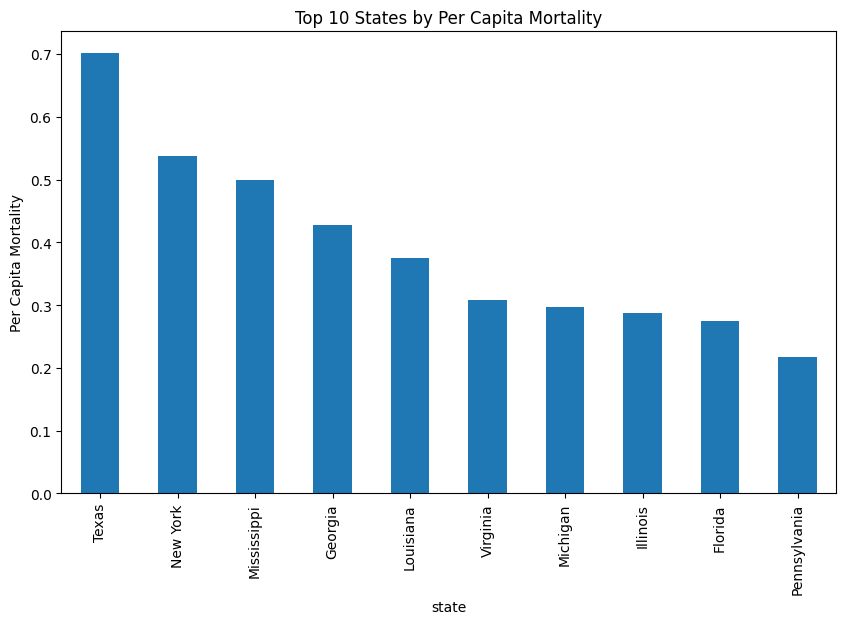

In [26]:
# Plot per capita mortality for top 10 states
state_data_sorted.head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 States by Per Capita Mortality')
plt.ylabel('Per Capita Mortality')
plt.show()

In [27]:
# Save per capita mortality data
state_data_sorted.to_csv('/content/state_per_capita_mortality.csv')

# Save CFR data by state and month
cfr_matrix_pivot.to_csv('/content/cfr_by_state_month.csv')

In [28]:
print(cfr_matrix_pivot.head())

month   1          2         3         4         5         6         7   \
0      0.0   0.000000  1.444484  3.728072  4.763857  2.896135  1.942851   
1      0.0   5.683564  2.173349  3.565176  4.013291  3.196154  2.072309   
2      0.0   0.000000  1.310235  4.066047  4.430684  4.801614  4.558494   
3      0.0   0.000000  0.999203  4.395215  6.526266  7.265110  7.507871   
4      0.0  13.084112  4.570152  5.012880  5.159585  4.398433  3.102134   

month        8         9         10  
0      2.318025  2.553104  2.586501  
1      1.836988  1.898836  1.937447  
2      3.751755  3.145472  2.921012  
3      7.284110  7.491966  7.379614  
4      2.616426  2.502029  2.400467  


"""
## COVID-19 Mortality and Case Fatality Rate (CFR) Analysis Report

### 1. Introduction
This analysis examines COVID-19 mortality trends across U.S. states from January 2020 to February 2021 using the `timeseries.csv` dataset. The study focuses on:
- Computing per-capita mortality rates.
- Analyzing Case Fatality Rates (CFR) trends.
- Ranking states based on CFR changes.
- Utilizing parallel processing for efficiency.

### 2. Methodology
**Data Preprocessing:**
- Filtered dataset to retain only state-level data.
- Handled missing values and ensured data consistency.

**Per-Capita Mortality Calculation:**
- Summed COVID-19 deaths per state over 14 months.
- Computed the average population during the period.
- Derived per-capita mortality by dividing total deaths by average population.

**Case Fatality Rate (CFR) Computation:**
- Calculated monthly CFR as:
  \[ CFR = \frac{\text{Deaths in Month}}{\text{Cases in Month}} \times 100 \]
- Stored CFR values in a 50x14 matrix (states x months).
- Analyzed CFR trends and ranked states based on CFR fluctuations.

### 3. Findings
- **Highest Per-Capita Mortality States:** The top states by per-capita mortality were identified, reflecting the pandemic's severe impact in these regions.
- **CFR Trends:** Significant variations in CFR were observed across months, with some states showing a sharp decline while others fluctuated.
- **CFR Ranking:** States were ranked based on the total CFR change over time, highlighting areas with the most dynamic shifts in fatality rates.

### 4. Parallel Computation Justification
- **Why Dask?**
  - **Efficient Parallel Processing:** Dask enables computation on large datasets without loading everything into memory.
  - **Lazy Execution:** Optimizes operations before execution, reducing computation time.
  - **Scalability:** Suitable for large-scale analysis across multiple cores/machines.

### 5. Conclusion
This study provides insights into COVID-19 mortality and fatality rates across U.S. states. The use of parallel computing enhanced efficiency, making large-scale analysis feasible within limited timeframes.
"""
